In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read in data
data = pd.read_csv("Asylum_seekers_per_country_per_year_w_next_year_12_3.csv")

In [4]:
# Create current_population feature
curr_pop_list = []
for index, row in data.iterrows():
    curr_year = str(int(row.Year))
    curr_pop = row[curr_year]
    curr_pop_list.append(curr_pop)
data['current_population']=curr_pop_list

# [Not very useful] Create before_2015 feature
#data['before_2015'] = (data['Year']<2015).astype(int)

In [5]:
# Remove N/A's in Gdelt fields and current_population (these are mismatched countries, bad records anyways)
print(data.shape)
data = data.dropna(subset=['QuadClass','NuMentions'])
print(data.shape)
data = data.dropna(subset=['current_population'])
print(data.shape)
# Remove N/A's in economic data (hopefully we'll fill some of these)
data = data.dropna(subset=['Unemployment Rate',
                           'GDP Per Capita',
                           'Life expectancy',])

data.shape

(3757, 124)
(3717, 124)
(3576, 124)


(3508, 124)

In [6]:
# Create y vector, 2000-2017
years = np.arange(2000,2017)
# Tried removing 2014 and 2015, but not very impactful
#years = np.delete(years,[14,15],axis=0)

y = data.loc[data.Year.isin(years),'applied_next_year']

# Log of y, the +0.5 adjustment to avoid ln(0) = -inf
y_ln = np.log(y+0.5)

# Create X feature matrix, including only the columns that we want to predict on in feature_list
feature_list = [
    'Applied during year_x',
    'current_population',
    'Unemployment Rate',
    'GDP Per Capita',
    'Life expectancy',
    'GoldsteinScale',
    'NuMentions',
    'AvgTone',
    'QuadClass',
    'Goldstein_Neg_5',
    'Goldstein_Neg_6',
    'Goldstein_Neg_7',
    'Goldstein_Neg_8',
    'Goldstein_Neg_9',
    'Goldstein_Pos_5',
    'Goldstein_Pos_6',
    'Goldstein_Pos_7',
    'Goldstein_Pos_8',
    'Goldstein_Pos_9',
    'Quad_4_Goldstein_Neg_5',
    'Quad_4_Goldstein_Neg_6',
    'Quad_4_Goldstein_Neg_7',
    'Quad_4_Goldstein_Neg_8',
    'Quad_4_Goldstein_Neg_9',
    'Event_Code_19_20',
    'Extreme_Pos_Tone_Events',
    'Extreme_Neg_Tone_Events'
    ]
X = data.loc[data.Year.isin(years),feature_list]

Text(0, 0.5, 'Histogram Number of country-years')

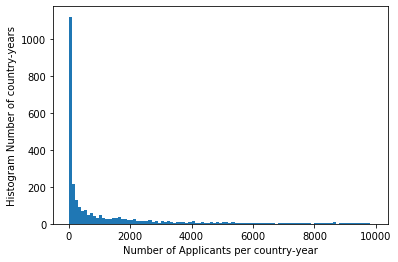

In [7]:
# Plot the histogram of applicant counts per country-year
bin_arr = np.arange(0,10000,100)

plt.hist(y,bins=bin_arr)
plt.xlabel("Number of Applicants per country-year")
plt.ylabel("Histogram Number of country-years")

Text(0, 0.5, 'Histogram Number of country-years')

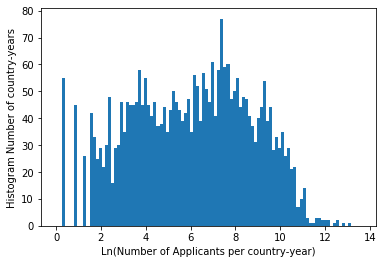

In [8]:
# Plot the histogram of ln(applicant counts per country-year)

bin_arr_ln = np.arange(0,y_ln.max(),y_ln.max()/100)

plt.hist(y_ln,bins=bin_arr_ln)
plt.xlabel("Ln(Number of Applicants per country-year)")
plt.ylabel("Histogram Number of country-years")

In [9]:
# Check for columns with N/A's and count the N/A's
for col in X:
    if X[col].isna().any():
        print(col,X[col].value_counts(dropna=False))

In [10]:
# Modeling!
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
#import xgboost as xgb

# Normalize X and y
# Note: I'm normalizing (setting mean to 0) not standardizing (setting variance to 1)
transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)

#Train_test_split, post-normalizing
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_ln, test_size=0.2)

In [ ]:
# Function for trying out models
def test_reg(reg,X_train, X_test, y_train, y_test, index, return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    print(reg,"\nr^2: ",r2_score(y_test,preds),"\n")

    model_name = ['Linear Regression', 'ElasticNetCV', 'Decision Tree Regressor',
                 'Random Forest Regressor', 'Gradient Boosting Regressor'][index]
    plt.figure(index)
    residuals = y_test-preds
    plt.title('Residuals: ' + model_name)
    plt.ylabel('Residual')
    plt.xlabel('Y test - ln(applicants in 2018)')
    plt.scatter(preds, residuals)

    
    
    if return_reg:
        return reg

# Instantiate the regressors
LR_reg = linear_model.LinearRegression()
EN_reg = linear_model.ElasticNetCV(cv=10)
DT_reg = tree.DecisionTreeRegressor()
RF_reg = ensemble.RandomForestRegressor(n_estimators=100)
GB_reg = ensemble.GradientBoostingRegressor()
#XGB_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Train and test all models with default settings
for index, model  in enumerate([LR_reg,EN_reg,DT_reg,RF_reg,GB_reg]):
    test_reg(model,X_train, X_test, y_train, y_test, index) 

In [ ]:
# Random Forest provides feature_importance...not rock solid, but useful for some context
RF_reg.fit(X_train,y_train)

for name,imp in zip(X.columns,RF_reg.feature_importances_):
    print("{}: {:2.2}".format(name,imp))

In [ ]:
'''# Hyperparameter tuning for the RandomForest model
# NOTE: This still isn't working very well.  I'm yet to get a model that beats the defaults.
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = ensemble.RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Make preds and calculate R^2
RF_optimized = best_grid = grid_search.best_estimator_
preds = best_grid.predict(X_test)
print(best_grid,"\nr^2: ",r2_score(y_test,preds),"\n")'''

## Test Data: 2018

In [15]:
# Dependent Variable
y_17 = data.loc[data.Year==2017,'applied_next_year']

y_ln_17 = np.log(y_17+0.5)

# Feature Matrix
X_17 = data.loc[data.Year==2017,feature_list]

transformer_17 = Normalizer().fit(X_17)
X_norm_17 = transformer_17.transform(X_17)


In [16]:
# Predict on 2017
def pred_2017(reg,X_17, y_17):
    '''Takes a trained model and the final test X and test y, in this case 2017 data.'''
    preds = reg.predict(X_17)
    print(reg,"\nr^2: ",r2_score(y_17,preds),"\n")

# Run with best performing model
pred_2017(RF_reg,X_norm_17,y_ln_17)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
r^2:  0.9307999924239471 

